# Training an image classifier

In [1]:
import torch

print("torch-version:", torch.__version__)
print("Available GPU:", torch.cuda.current_device())

torch-version: 1.1.0
Available GPU: 0


## 1. Loading and normalizing CIFAR10

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(trainset.__getitem__(0)[0].size(), trainset.__len__())
print(testset.__getitem__(0)[0].size(), testset.__len__())

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) 50000
torch.Size([3, 32, 32]) 10000


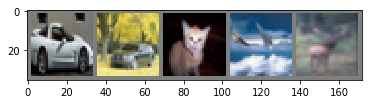

  car   car   cat plane  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

## 2. Define a CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

## 3. Define a Loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [7]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %(epoch + 1, running_loss / 10))
        running_loss = 0.0
        #torch.save(model,'./data/cifar_model.pkl')

print('Finished Training')

[1] loss: 11.294
[11] loss: 11.217
[21] loss: 10.239
[31] loss: 9.322
[41] loss: 8.808
Finished Training


In [8]:
from pprint import pprint

param_list = list(net.children())
pprint(param_list)

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)),
 Linear(in_features=400, out_features=120, bias=True),
 Linear(in_features=120, out_features=84, bias=True),
 Linear(in_features=84, out_features=10, bias=True)]


## 5. Test the network on the test data

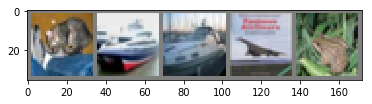

GroundTruth:    cat  ship  ship plane  frog
Predicted:    cat  ship  ship  ship  frog


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:5]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

#
outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

In [10]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %(100 * correct / total))

Accuracy of the network on the 10000 test images: 38 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(784):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 46 %
Accuracy of  bird : 13 %
Accuracy of   cat : 16 %
Accuracy of  deer : 23 %
Accuracy of   dog : 40 %
Accuracy of  frog : 54 %
Accuracy of horse : 55 %
Accuracy of  ship : 45 %
Accuracy of truck : 42 %
